# Recommendation Systems Assignment

### MIE451/1513 UofT

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [1]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wget
#import turicreate

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=499e39e50b65817179b8d511caed6b147cd2e09250e5084e7fd01da47109d1fb
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


## Support functions and variables

In [2]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [3]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [0]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [0]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [6]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
rating_df.tail()

,userID,itemID,rating,timestamp
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156
99999,12,203,3,879959583


In [8]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


## Q1

### (a)

In [0]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    # Initialize a of size (numUsers, numItems) to zeros
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    return matrix
    
    
    ###########         end         ###########
    return matrix

In [10]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

In [11]:
np.isfinite(rating_df).any()

userID       True
itemID       True
rating       True
timestamp    True
dtype: bool

### (b)

In [0]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros

        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                # select the row for user
                # what's the shape of userVector? The User vector is 1 * I
                userVector = train_matrix[user, :]

                # Extract the items the user already rated
                ratedItems = userVector[userVector.nonzero()] # This can find all non zero values

                # If not empty, calculate average and set as rating for the current item
                if ratedItems.size == 0:
                    itemAvg = 0
                else:
                    itemAvg = ratedItems.mean()
                predictionMatrix[user, item] = itemAvg

            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))


        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0]) #nonzero[0] function just return the non zero index. len() check how many nonzero terms
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0]) # number of user like > 4 rating
            if numOfUsersRated == 0: # means no one has ever rated this item
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated # like rate

        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]

            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))

                
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [0]:
popularity_recsys = BaseLineRecSys('popularity')

In [14]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [15]:
x = popularity_recsys.getModel()
x

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       [0.71017699, 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       [0.71017699, 0.38931298, 0.37777778, ..., 0.        , 0.        ,
        0.        ],
       [0.71017699, 0.        , 0.37777778, ..., 0.        , 0.        ,
        0.        ]])

In [16]:
np.all(x<=1)

True

In [17]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [18]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:21, 1230.88it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


In [0]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [20]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [21]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.61029412, 3.61029412,
        3.61029412],
       [0.        , 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [22]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:20, 1242.26it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


## Q2

### (a)

In [0]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########
        similarity_matrix = 1 / (pairwise_distances(matrix, metric='euclidean') + 1)
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
        similarity_matrix = 1 / (pairwise_distances(matrix, metric = 'manhattan') + 1)

    
    
        ###########         end         ###########        
        return similarity_matrix
    
       
    
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1 #zeros are those non-ratings
            # set up uu_sim and return sim matrix for 3 methods
            uu_similarity = self.method(train_matrix)
            # normalize
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer==0] = 1e-5
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            # np.matmul(uu_similarity, trainSet) dimension is U * U mul U * I = U * I
            # predictionMatrix[temp_matrix.nonzero()] = 0
            # Cold start
            # if no one has rated this item before, use user average  
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            print(predictionMatrix.shape)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            
            self.__model = predictionMatrix
            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########
            train_matrix = train_matrix.T
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            ii_similarity = self.method(train_matrix)
            normalizer = np.matmul(ii_similarity, temp_matrix)
            normalizer[normalizer==0] = 1e-5
            predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer
            
            itemaverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1) + 1e-5)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)

            # here the matrix is I * U,  we need U * I

            
            self.__model = predictionMatrix.T

            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [24]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [25]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [26]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

### (b)

## Q3

### (a)

In [27]:
user_cosine_recsys = SimBasedRecSys('user','cosine')
user_cosine_recsys.predict_all(rating_df, num_users, num_items)
user_cosine_recsys.getModel()

(943, 1682)


array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [28]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [29]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:33, 1072.99it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


In [0]:
### Item - cos sim 

In [31]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

item_cosine_recsys.predict_all(rating_df, num_users, num_items)

item_cosine_recsys.getModel()

array([[3.75429099, 3.66419957, 3.73222997, ..., 3.60248287, 3.79662696,
        3.90232044],
       [3.83658867, 3.80424519, 3.77473905, ..., 3.72798332, 3.9109779 ,
        3.79775927],
       [2.84492718, 2.89389328, 2.84327324, ..., 2.99504451, 3.16444153,
        2.9858119 ],
       ...,
       [4.11427954, 4.0558267 , 4.00963139, ..., 4.        , 3.87872799,
        4.14814803],
       [4.37096823, 4.39679254, 4.33543016, ..., 3.955358  , 4.41891089,
        4.57995134],
       [3.52030345, 3.46948821, 3.52393064, ..., 0.        , 3.6110641 ,
        3.59656861]])

In [32]:
item_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:21, 1234.08it/s]


,userID,itemID,rating,timestamp,item-cosine
0,196,242,3,881250949,3.591314
1,186,302,3,891717742,3.344077
2,22,377,1,878887116,2.965365
3,244,51,2,880606923,3.637332
4,166,346,1,886397596,3.333013


### (b)

In [0]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                #print(fold_scores)
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
            #print(ci_low)
        results = scores    
    
        return results
            

In [0]:
# How to use CrossValidation Class?

In [35]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [user_cosine_recsys, item_cosine_recsys]

# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K

cv_methods = ['RMSE','P@K','R@K']
#cv_patk = CrossValidation('P@K')
#cv_ratk = CrossValidation('R@K')
cv_rmse = CrossValidation('RMSE')
# 3. Run CV by giving:
#patk_results = cv_patk.run(algorithm_instances, num_users, num_items,k=5).items()
#ratk_results = cv_ratk.run(algorithm_instances, num_users, num_items,k=5).items()
rmse_results = cv_rmse.run(algorithm_instances, num_users, num_items,k=5).items()

Processing algorithm user-cosine


156it [00:00, 1552.27it/s]

(943, 1682)


20000it [00:08, 2230.39it/s]
169it [00:00, 1680.48it/s]

(943, 1682)


20000it [00:08, 2234.37it/s]
165it [00:00, 1648.43it/s]

(943, 1682)


20000it [00:08, 2270.33it/s]
169it [00:00, 1681.44it/s]

(943, 1682)


20000it [00:08, 2275.93it/s]
171it [00:00, 1704.18it/s]

(943, 1682)


20000it [00:08, 2271.93it/s]


Processing algorithm item-cosine


20000it [00:08, 2250.10it/s]
20000it [00:08, 2242.26it/s]
20000it [00:08, 2239.11it/s]
20000it [00:08, 2268.42it/s]
20000it [00:08, 2253.52it/s]


In [37]:
print('\t\tMetric: RMSE')
print('Method\t\tMean\t\t\tCI_low\t\t\tCI_high')
for k, v  in rmse_results:
    print('{0}\t{1}\t{2}\t{3}'.format(k, v[1], v[2], v[3]))


		Metric: RMSE
Method		Mean			CI_low			CI_high
user-cosine	1.0173541216605808	1.009013080226148	1.0256951630950135
item-cosine	1.020082900106248	1.0068242686250732	1.0333415315874226


## Q4

### (a)

In [0]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lamb=da: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########
    
        self.w_Item = np.random.normal(0, 0.1, size = (num_item, self.num_feat))  # item M x D 
        self.w_User = np.random.normal(0, 0.1, size = (num_user, self.num_feat))  # user N x D 
    
    
        ###########         end         ###########  
        
        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  # 1-1000
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            
            for batch in range(self.num_batches): # FOR EACH BATCH = EACH ROW
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index, np.mod = reminder
                # This step is just to get a random batch index 


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32') # different userId and ItemId
                # 1000 ID and Item
                
                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ########### 
                
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :], self.w_Item[batch_ItemID, :]), axis = 1)
                #print(self.w_User[batch_UserID, :])
                #return one value from UV matrix
                
            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]
                #print(rawErr.shape)
                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
                    #print(self.w_Item.shape)
                    #print(np.multiply(train_vec[train_user_idx, 2], train_vec[train_item_idx, 2]))
                    
                    pred_out = np.sum(np.multiply(self.w_User[train_user_idx, :], self.w_Item[train_item_idx, :]), axis = 1) # size(pairs_train, )
                    #print(pred_out)
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
                    pred_out = np.sum(np.multiply(self.w_User[val_user_idx, :], self.w_Item[val_item_idx, :]), axis = 1) #size(pairs_val, )             
                   
                    
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))
            #print(pred_out.shape)

        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)

In [0]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 20, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})

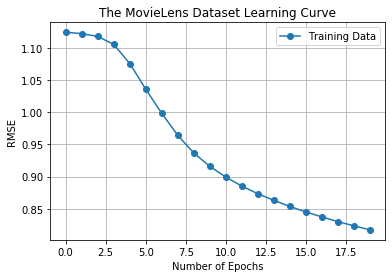

In [40]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

## Q5

In [41]:
algorithm_instances = [ 
                      pmf,
popularity_recsys]
cv_methods = ['RMSE','P@K','R@K']
#cv_patk = CrossValidation('P@K')
#cv_ratk = CrossValidation('R@K')
cv_rmse = CrossValidation('RMSE')
# 3. Run CV by giving:
#patk_results = cv_patk.run(algorithm_instances, num_users, num_items,k=5).items()
#ratk_results = cv_ratk.run(algorithm_instances, num_users, num_items,k=5).items()
rmse_results = cv_rmse.run(algorithm_instances, num_users, num_items,k=5).items()

Processing algorithm PMF


20000it [00:15, 1288.43it/s]
20000it [00:15, 1305.42it/s]
20000it [00:15, 1299.71it/s]
20000it [00:15, 1303.84it/s]
20000it [00:15, 1315.42it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:08, 2263.19it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:08, 2267.82it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:08, 2265.33it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:08, 2255.53it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:08, 2231.26it/s]


### (a)

In [42]:

# 1. gather your algorithms in previous steps.
algorithm_instances = [
                       popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys,
                      item_cosine_recsys,
                      pmf
                      ]

# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K

cv_methods = ['RMSE','P@K','R@K']
cv_patk = CrossValidation('P@K')
cv_ratk = CrossValidation('R@K')
cv_rmse = CrossValidation('RMSE')
# 3. Run CV by giving:
patk_results = cv_patk.run(algorithm_instances, num_users, num_items,k=5).items()
ratk_results = cv_ratk.run(algorithm_instances, num_users, num_items,k=5).items()
rmse_results = cv_rmse.run(algorithm_instances, num_users, num_items,k=5).items()

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:08, 2234.66it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:08, 2235.72it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:08, 2253.54it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:08, 2237.53it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:08, 2241.77it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:08, 2225.08it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:08, 2245.14it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:08, 2266.26it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:08, 2285.08it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:08, 2258.20it/s]


Processing algorithm user-cosine


159it [00:00, 1587.53it/s]

(943, 1682)


20000it [00:09, 2215.87it/s]
147it [00:00, 1468.80it/s]

(943, 1682)


20000it [00:08, 2238.37it/s]
157it [00:00, 1564.59it/s]

(943, 1682)


20000it [00:08, 2230.83it/s]
155it [00:00, 1543.50it/s]

(943, 1682)


20000it [00:08, 2249.56it/s]
163it [00:00, 1629.00it/s]

(943, 1682)


20000it [00:08, 2261.97it/s]


Processing algorithm item-cosine


20000it [00:08, 2244.80it/s]
20000it [00:08, 2261.19it/s]
20000it [00:08, 2239.22it/s]
20000it [00:08, 2252.45it/s]
20000it [00:08, 2262.78it/s]


Processing algorithm PMF


20000it [00:15, 1307.15it/s]
20000it [00:15, 1295.29it/s]
20000it [00:15, 1299.17it/s]
20000it [00:15, 1300.65it/s]
20000it [00:15, 1306.02it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:08, 2248.14it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:08, 2244.29it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:08, 2238.81it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:08, 2262.21it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:08, 2243.18it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:08, 2242.12it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:08, 2226.61it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:08, 2245.35it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:08, 2233.83it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:08, 2240.46it/s]


Processing algorithm user-cosine


162it [00:00, 1612.47it/s]

(943, 1682)


20000it [00:08, 2239.00it/s]
164it [00:00, 1639.35it/s]

(943, 1682)


20000it [00:08, 2244.82it/s]
144it [00:00, 1433.83it/s]

(943, 1682)


20000it [00:09, 2222.01it/s]
157it [00:00, 1561.07it/s]

(943, 1682)


20000it [00:09, 2202.95it/s]
160it [00:00, 1594.19it/s]

(943, 1682)


20000it [00:08, 2236.14it/s]


Processing algorithm item-cosine


20000it [00:08, 2228.18it/s]
20000it [00:08, 2235.58it/s]
20000it [00:09, 2213.70it/s]
20000it [00:09, 2220.28it/s]
20000it [00:08, 2233.40it/s]


Processing algorithm PMF


20000it [00:15, 1307.32it/s]
20000it [00:15, 1290.09it/s]
20000it [00:15, 1292.13it/s]
20000it [00:15, 1294.57it/s]
20000it [00:15, 1297.65it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2208.14it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2217.42it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2220.96it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:08, 2235.15it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:08, 2223.92it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:08, 2244.07it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:08, 2269.39it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:08, 2267.95it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:08, 2239.02it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:08, 2269.55it/s]


Processing algorithm user-cosine


161it [00:00, 1605.09it/s]

(943, 1682)


20000it [00:09, 2213.52it/s]
147it [00:00, 1469.78it/s]

(943, 1682)


20000it [00:08, 2229.30it/s]
162it [00:00, 1614.57it/s]

(943, 1682)


20000it [00:08, 2223.84it/s]
165it [00:00, 1642.68it/s]

(943, 1682)


20000it [00:09, 2207.24it/s]
168it [00:00, 1670.01it/s]

(943, 1682)


20000it [00:09, 2207.12it/s]


Processing algorithm item-cosine


20000it [00:08, 2238.55it/s]
20000it [00:09, 2198.21it/s]
20000it [00:09, 2213.74it/s]
20000it [00:09, 2190.68it/s]
20000it [00:08, 2251.28it/s]


Processing algorithm PMF


20000it [00:15, 1305.14it/s]
20000it [00:15, 1301.89it/s]
20000it [00:15, 1297.30it/s]
20000it [00:15, 1307.22it/s]
20000it [00:15, 1304.35it/s]


In [43]:
print('\t\tMetric: RMSE')
print('Method\t\tMean\t\t\tCI_low\t\t\tCI_high')
for k, v  in rmse_results:
    print('{0}\t{1}\t{2}\t{3}'.format(k, v[1], v[2], v[3]))
    
print('\t\tMetric: P@K')
print('Method\t\tMean\t\t\tCI_low\t\t\tCI_high')
for k, v  in patk_results:
    print('{0}\t{1}\t{2}\t{3}'.format(k, v[1], v[2], v[3]))

print('\t\tMetric: R@K')
print('Method\t\tMean\t\t\tCI_low\t\t\tCI_high')
for k, v  in ratk_results:
    print('{0}\t{1}\t{2}\t{3}'.format(k, v[1], v[2], v[3]))

		Metric: RMSE
Method		Mean			CI_low			CI_high
popularity	3.1590928909890112	3.139292746995387	3.1788930349826354
useraverage	1.0437176561595025	1.0289303496379316	1.0585049626810734
user-cosine	1.0173541216605808	1.009013080226148	1.0256951630950135
item-cosine	1.020082900106248	1.0068242686250732	1.0333415315874226
PMF	0.9391145382358351	0.9254226182952648	0.9528064581764054
		Metric: P@K
Method		Mean			CI_low			CI_high
popularity	0.5505832449628855	0.40544114481568705	0.6957253451100839
useraverage	0.4736373276776259	0.3419993013451059	0.6052753540101459
user-cosine	0.5558430540827157	0.40959849499983714	0.7020876131655943
item-cosine	0.5322163308589621	0.3837005215009889	0.6807321402169354
PMF	0.555334040296926	0.41135268034184413	0.6993154002520079
		Metric: R@K
Method		Mean			CI_low			CI_high
popularity	0.4840758878843688	0.3671373629798323	0.6010144127889052
useraverage	0.44132320502242983	0.32931026359142457	0.5533361464534351
user-cosine	0.4862687235536437	0.3694473610987218	0

### (b)

R@k is the best way to evaluate, because users want to know exactly which one to watch.

RMSE is sufficient for ranking but is not the best method

## Q6

### (a)

In [0]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

In [0]:
pd.set_option('display.max_rows', 500)

In [46]:
moviesDF.head(500)

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,NaN,http://us.imdb.com/Title?Yao+a+yao+yao+dao+wai...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
7,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0
8,9,Dead Man Walking (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,10,Richard III (1995),22-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Richard%20III...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [47]:
moviesDF.iloc[221][['movieTitle']]

movieTitle    Star Trek: First Contact (1996)
Name: 221, dtype: object

In [0]:
# top 5 according to cos sim
train_matrix = dataPreprocessor(rating_df, num_users, num_items)
ii_similarity = SimBasedRecSys.cosine(train_matrix.T)

In [49]:

def TOP5_IIsim(ii_similarity, movieID, movieName):
    ii_vector = ii_similarity[movieID-1]
    idx = np.argsort(ii_vector)[::-1][1:6]
    top5 = list(map(lambda x: moviesDF[moviesDF.movieID ==x+1]['movieTitle'].values[0],idx))
    print('Top 5 most similar movies of {} are\n{}\n'.format(movieName, top5))
TOP5_IIsim(ii_similarity, 180, 'Return of the Jedi')
TOP5_IIsim(ii_similarity, 221, 'Star Trek: First Contact')
TOP5_IIsim(ii_similarity, 126, 'Godfather, The')

Top 5 most similar movies of Return of the Jedi are
['2001: A Space Odyssey (1968)', "One Flew Over the Cuckoo's Nest (1975)", 'Clockwork Orange, A (1971)', 'Raiders of the Lost Ark (1981)', 'Silence of the Lambs, The (1991)']

Top 5 most similar movies of Star Trek: First Contact are
['Big Night (1996)', 'Lone Star (1996)', 'Secrets & Lies (1996)', 'Postino, Il (1994)', 'Angels and Insects (1995)']

Top 5 most similar movies of Godfather, The are
['Jerry Maguire (1996)', "Mr. Holland's Opus (1995)", 'Courage Under Fire (1996)', 'Fargo (1996)', 'First Wives Club, The (1996)']



### (b)

the result does not match exactly

## Q7

### (a)

In [50]:
rating_df.shape

(100000, 4)

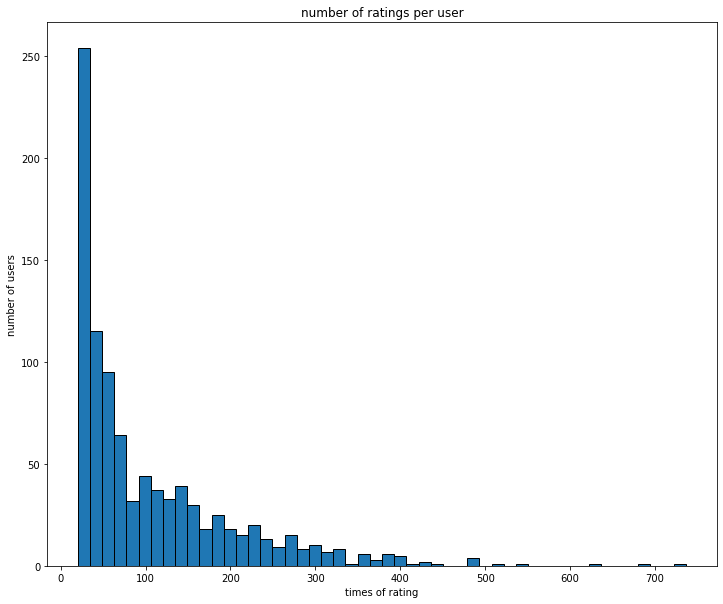

In [51]:
temp_matrix = np.zeros(train_matrix.shape)
temp_matrix[train_matrix.nonzero()] = 1

# one column list of rating times by 943 users
rating_times = np.sum(temp_matrix, axis = 1)

fig = plt.figure(figsize=(12,10))
#ax = fig.gca()
plt.hist(rating_times, bins = 50, edgecolor='black', linestyle="-")
plt.title('number of ratings per user')
plt.xlabel('times of rating')
plt.ylabel('number of users')
plt.show()

In [0]:
# set mean ratings times as the threshold.

user_above_mean = train_matrix[rating_times >= np.mean(rating_times)]
user_below_mean = train_matrix[rating_times < np.mean(rating_times)]

# set 50 ratings times as the threshold.
user_above_50 = train_matrix[rating_times >= 50]
user_below_50 = train_matrix[rating_times < 50]

In [53]:
np.mean(rating_times)

106.04453870625663

In [54]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [55]:
user_below_mean.shape

(604, 1682)

In [56]:
num_users_above_mean = len(user_above_mean)
num_users_below_mean = len(user_below_mean)

num_items_mean = len(user_below_mean)
print("Number of users above mean:", num_users_above_mean)
print("Number of users below mean:", num_users_below_mean)
print("Number of items:", num_items)

Number of users above mean: 339
Number of users below mean: 604
Number of items: 1682


In [0]:
def rmse_th(train_matrix, base):

    
    if base == 'user':
        ########### your code goes here ###########
        temp_matrix = np.zeros(train_matrix.shape)
        temp_matrix[train_matrix.nonzero()] = 1
        uu_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')
        normalizer = np.matmul(uu_similarity, temp_matrix)
        normalizer[normalizer==0] =1e-5
        predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer


        useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1) + 1e-5)
        columns = np.sum(predictionMatrix, axis=0)
        predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
        print(predictionMatrix.shape)
        __model = predictionMatrix
        #return __model


    elif base == 'item':
        ########### your code goes here ###########
        train_matrix = train_matrix.T
        temp_matrix = np.zeros(train_matrix.shape)
        temp_matrix[train_matrix.nonzero()] = 1
        ii_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')
        normalizer = np.matmul(ii_similarity, temp_matrix)
        normalizer[normalizer==0] = 1e-5
        predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer

        itemaverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1) + 1e-5)
        columns = np.sum(predictionMatrix, axis=0)
        predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
        print(predictionMatrix.shape)

        __model = predictionMatrix
        #return __model

      
    
    # calculate RMSE for all the items in the test dataset
    pred_array = __model[train_matrix.nonzero()].flatten() 
    test_array = train_matrix[train_matrix.nonzero()].flatten()
    return sqrt(mean_squared_error(pred_array, test_array))
    

In [58]:
rmse_th(user_above_mean, 'user')

(339, 1682)


0.9475766507819539

In [59]:
rmse_th(user_above_mean, 'item')

(1682, 339)


0.9950530759852194

In [60]:
rmse_th(user_below_mean, 'user')

(604, 1682)


0.8950248547013733

In [61]:
rmse_th(user_below_mean, 'item')

(1682, 604)


0.9011269940564665

# Validation

In [0]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [0]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [0]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [0]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [70]:
validatePopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


### User Average Based Recommendation

In [0]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [72]:
validateUserAverRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [0]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [0]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [0]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [0]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [0]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [78]:
validateUUSimBasedRecSys()

(943, 1682)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide


### Item-Item Similarity Based Recommendation System

In [0]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateIISimBasedRecSys()

### Probabilistic Matrix Factorization Recommendation System

In [0]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate PMFRecSys")
        return
    
    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [0]:
validatePMFRecSys(validation_df=validation_df)